<a href="https://colab.research.google.com/github/cp3xl/yolt/blob/master/HybridSN_%E9%AB%98%E5%85%89%E8%B0%B1%E5%88%86%E7%B1%BB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HybridSN 高光谱分类


首先取得数据，并引入基本函数库。

In [ ]:
! wget http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat
! wget http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat
! pip install spectral

--2021-01-04 07:18:20--  http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5953527 (5.7M)
Saving to: ‘Indian_pines_corrected.mat’

Indian_pines_correc 100%[===================>]   5.68M   713KB/s    in 9.2s    

2021-01-04 07:18:29 (634 KB/s) - ‘Indian_pines_corrected.mat’ saved [5953527/5953527]

--2021-01-04 07:18:29--  http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1125 (1.1K)
Saving to: ‘Indian_pines_gt.mat’

Indian_pines_gt.mat 100%[===================>]   1.10K  --.-KB/s    in 0s      

2021-01-04 07:18:30 (168 MB/s) - ‘Indian_pines_gt.mat’ saved [1125/1125]

  

## 1 定义HybridSN类

![](https://camo.githubusercontent.com/f7db2d6ed93212a9b4d31c2826e38a2bdd964311/68747470733a2f2f67616f707572737569742e6f73732d636e2d6265696a696e672e616c6979756e63732e636f6d2f3230323030332f32303230303330343230333731302e6a7067)

三维卷积部分：

conv1：（1, 30, 25, 25）， 8个 7x3x3 的卷积核 ==>（8, 24, 23, 23）
conv2：（8, 24, 23, 23）， 16个 5x3x3 的卷积核 ==>（16, 20, 21, 21）
conv3：（16, 20, 21, 21），32个 3x3x3 的卷积核 ==>（32, 18, 19, 19）
接下来要进行二维卷积，因此把前面的 32*18 reshape 一下，得到 （576, 19, 19）

二维卷积：（576, 19, 19） 64个 3x3 的卷积核，得到 （64, 17, 17）

接下来是一个 flatten 操作，变为 18496 维的向量，

接下来依次为256，128节点的全连接层，都使用比例为0.4的 Dropout，

最后输出为 16 个节点，是最终的分类类别数。

下面是 HybridSN 类的代码：

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
import spectral
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import copy

In [ ]:
class_num = 16

class HybridSN(nn.Module):  
  def __init__(self, in_channels=1, out_channels=class_num):
    super(HybridSN, self).__init__()
    self.conv3d_features = nn.Sequential(
        nn.Conv3d(in_channels,out_channels=8,kernel_size=(7,3,3)),
        nn.ReLU(),
        nn.Conv3d(in_channels=8,out_channels=16,kernel_size=(5,3,3)),
        nn.ReLU(),
        nn.Conv3d(in_channels=16,out_channels=32,kernel_size=(3,3,3)),
        nn.ReLU()
    )

    self.conv2d_features = nn.Sequential(
        nn.Conv2d(in_channels=32 * 18, out_channels=64, kernel_size=(3,3)),
        nn.ReLU()
    )

    self.classifier = nn.Sequential(
        nn.Linear(64 * 17 * 17, 256),
        nn.ReLU(),
        nn.Dropout(p=0.4),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Dropout(p=0.4),
        nn.Linear(128, 16)
    )
 
  def forward(self, x):
    x = self.conv3d_features(x)
    x = x.view(x.size()[0],x.size()[1]*x.size()[2],x.size()[3],x.size()[4])
    x = self.conv2d_features(x)
    x = x.view(x.size()[0],-1)
    x = self.classifier(x)
    return x

In [ ]:
# 随机输入，测试网络结构是否通
x = torch.randn(4, 1, 30, 25, 25)
net = HybridSN()
y = net(x)
print(y.shape)

torch.Size([4, 16])


## 2 创建数据集

# 新段落

首先对高光谱数据实施PCA降维；然后创建 keras 方便处理的数据格式；然后随机抽取 10% 数据做为训练集，剩余的做为测试集。

首先定义基本函数：

In [ ]:
# 对高光谱数据 X 应用 PCA 变换
def applyPCA(X, numComponents):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0], X.shape[1], numComponents))
    return newX

# 对单个像素周围提取 patch 时，边缘像素就无法取了，因此，给这部分像素进行 padding 操作
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

# 在每个像素周围提取 patch ，然后创建成符合 keras 处理的格式
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    # 给 X 做 padding
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState, stratify=y)
    return X_train, X_test, y_train, y_test

# 新段落

下面读取并创建数据集：

In [ ]:
# 地物类别
class_num = 16
X = sio.loadmat('Indian_pines_corrected.mat')['indian_pines_corrected']
y = sio.loadmat('Indian_pines_gt.mat')['indian_pines_gt']

# 用于测试样本的比例
test_ratio = 0.90
# 每个像素周围提取 patch 的尺寸
patch_size = 25
# 使用 PCA 降维，得到主成分的数量
pca_components = 30

print('Hyperspectral data shape: ', X.shape)
print('Label shape: ', y.shape)

print('\n... ... PCA tranformation ... ...')
X_pca = applyPCA(X, numComponents=pca_components)
print('Data shape after PCA: ', X_pca.shape)

print('\n... ... create data cubes ... ...')
X_pca, y = createImageCubes(X_pca, y, windowSize=patch_size)
print('Data cube X shape: ', X_pca.shape)
print('Data cube y shape: ', y.shape)

print('\n... ... create train & test data ... ...')
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X_pca, y, test_ratio)
print('Xtrain shape: ', Xtrain.shape)
print('Xtest  shape: ', Xtest.shape)

# 改变 Xtrain, Ytrain 的形状，以符合 keras 的要求
Xtrain = Xtrain.reshape(-1, patch_size, patch_size, pca_components, 1)
Xtest  = Xtest.reshape(-1, patch_size, patch_size, pca_components, 1)
print('before transpose: Xtrain shape: ', Xtrain.shape) 
print('before transpose: Xtest  shape: ', Xtest.shape) 

# 为了适应 pytorch 结构，数据要做 transpose
Xtrain = Xtrain.transpose(0, 4, 3, 1, 2)
Xtest  = Xtest.transpose(0, 4, 3, 1, 2)
print('after transpose: Xtrain shape: ', Xtrain.shape) 
print('after transpose: Xtest  shape: ', Xtest.shape) 

Hyperspectral data shape:  (145, 145, 200)
Label shape:  (145, 145)

... ... PCA tranformation ... ...
Data shape after PCA:  (145, 145, 30)

... ... create data cubes ... ...
Data cube X shape:  (10249, 25, 25, 30)
Data cube y shape:  (10249,)

... ... create train & test data ... ...
Xtrain shape:  (1024, 25, 25, 30)
Xtest  shape:  (9225, 25, 25, 30)
before transpose: Xtrain shape:  (1024, 25, 25, 30, 1)
before transpose: Xtest  shape:  (9225, 25, 25, 30, 1)
after transpose: Xtrain shape:  (1024, 1, 30, 25, 25)
after transpose: Xtest  shape:  (9225, 1, 30, 25, 25)


In [ ]:
""" Training dataset"""
class TrainDS(torch.utils.data.Dataset): 
    def __init__(self):
        self.len = Xtrain.shape[0]
        self.x_data = torch.FloatTensor(Xtrain)
        self.y_data = torch.LongTensor(ytrain)        
    def __getitem__(self, index):
        # 根据索引返回数据和对应的标签
        return self.x_data[index], self.y_data[index]
    def __len__(self): 
        # 返回文件数据的数目
        return self.len

""" Testing dataset"""
class TestDS(torch.utils.data.Dataset): 
    def __init__(self):
        self.len = Xtest.shape[0]
        self.x_data = torch.FloatTensor(Xtest)
        self.y_data = torch.LongTensor(ytest)
    def __getitem__(self, index):
        # 根据索引返回数据和对应的标签
        return self.x_data[index], self.y_data[index]
    def __len__(self): 
        # 返回文件数据的数目
        return self.len

# 创建 trainloader 和 testloader
trainset = TrainDS()
testset  = TestDS()
train_loader = torch.utils.data.DataLoader(dataset=trainset, batch_size=128, shuffle=True, num_workers=2)
test_loader  = torch.utils.data.DataLoader(dataset=testset,  batch_size=128, shuffle=False, num_workers=2)

## 3 开始训练

In [ ]:
def train(net):


  current_loss_his = []
  current_Acc_his = []

  best_net_wts = copy.deepcopy(net.state_dict())
  best_acc = 0.0

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(net.parameters(), lr=0.001)

  # 开始训练
  total_loss = 0
  for epoch in range(100):
      net.train()  # 将模型设置为训练模式
      for i, (inputs, labels) in enumerate(train_loader):
          inputs = inputs.to(device)
          labels = labels.to(device)
          # 优化器梯度归零
          optimizer.zero_grad()
          # 正向传播 +　反向传播 + 优化 
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          total_loss += loss.item()

      net.eval()   # 将模型设置为验证模式
      current_acc = test_acc(net)
      current_Acc_his.append(current_acc)

      if current_acc > best_acc:
        best_acc = current_acc
        best_net_wts = copy.deepcopy(net.state_dict())

      print('[Epoch: %d]   [loss avg: %.4f]   [current loss: %.4f]  [current acc: %.4f]' %(epoch + 1, total_loss/(epoch+1), loss.item(), current_acc))
      current_loss_his.append(loss.item())

  print('Finished Training')
  print("Best Acc:%.4f" %(best_acc))

  # load best model weights
  net.load_state_dict(best_net_wts)

  return net,current_loss_his,current_Acc_his


In [ ]:
def test_acc(net):
  count = 0
  # 模型测试
  for inputs, _ in test_loader:
      inputs = inputs.to(device)
      outputs = net(inputs)
      outputs = np.argmax(outputs.detach().cpu().numpy(), axis=1)
      if count == 0:
          y_pred_test =  outputs
          count = 1
      else:
          y_pred_test = np.concatenate( (y_pred_test, outputs) )

  # 生成分类报告
  classification = classification_report(ytest, y_pred_test, digits=4)
  index_acc = classification.find('weighted avg')
  accuracy = classification[index_acc+17:index_acc+23]
  return float(accuracy)

In [ ]:
# 使用GPU训练，可以在菜单 "代码执行工具" -> "更改运行时类型" 里进行设置
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 网络放到GPU上
net = HybridSN().to(device)
# 训练
net,current_loss_his,current_Acc_his = train(net)

[Epoch: 1]   [loss avg: 22.5075]   [current loss: 2.7349]  [current acc: 0.0574]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Epoch: 2]   [loss avg: 21.8608]   [current loss: 2.6093]  [current acc: 0.0574]
[Epoch: 3]   [loss avg: 21.2250]   [current loss: 2.4774]  [current acc: 0.0574]
[Epoch: 4]   [loss avg: 20.7184]   [current loss: 2.4383]  [current acc: 0.0574]
[Epoch: 5]   [loss avg: 20.3383]   [current loss: 2.4223]  [current acc: 0.0574]
[Epoch: 6]   [loss avg: 19.9677]   [current loss: 2.2148]  [current acc: 0.0574]
[Epoch: 7]   [loss avg: 19.5804]   [current loss: 2.0577]  [current acc: 0.0794]
[Epoch: 8]   [loss avg: 19.1345]   [current loss: 1.8743]  [current acc: 0.2067]
[Epoch: 9]   [loss avg: 18.5646]   [current loss: 1.6286]  [current acc: 0.2212]
[Epoch: 10]   [loss avg: 17.9343]   [current loss: 1.5080]  [current acc: 0.2620]
[Epoch: 11]   [loss avg: 17.3353]   [current loss: 1.4757]  [current acc: 0.4426]
[Epoch: 12]   [loss avg: 16.7405]   [current loss: 1.0903]  [current acc: 0.6117]
[Epoch: 13]   [loss avg: 16.1413]   [current loss: 0.8911]  [current acc: 0.6900]
[Epoch: 14]   [loss avg:

In [ ]:
current_loss_his

[2.734907865524292,
 2.6092827320098877,
 2.4774415493011475,
 2.43830943107605,
 2.4223458766937256,
 2.2147703170776367,
 2.057713508605957,
 1.8743252754211426,
 1.6285991668701172,
 1.5079761743545532,
 1.475677728652954,
 1.090346336364746,
 0.8911038041114807,
 0.9652518630027771,
 0.8615198731422424,
 0.592408299446106,
 0.5654528737068176,
 0.650113046169281,
 0.5294400453567505,
 0.4528641104698181,
 0.2900409400463104,
 0.2560333013534546,
 0.18199101090431213,
 0.18979087471961975,
 0.1976805031299591,
 0.08788677304983139,
 0.09632417559623718,
 0.19992294907569885,
 0.17216435074806213,
 0.14331185817718506,
 0.2145216017961502,
 0.10541955381631851,
 0.08797848969697952,
 0.08415360003709793,
 0.045634228736162186,
 0.0589091032743454,
 0.05081522464752197,
 0.05414099991321564,
 0.19356678426265717,
 0.0335070937871933,
 0.06241166591644287,
 0.05951357260346413,
 0.033231887966394424,
 0.016002293676137924,
 0.12953658401966095,
 0.034616563469171524,
 0.007896108552813

In [ ]:
current_Acc_his

[0.0574,
 0.0574,
 0.0574,
 0.0574,
 0.0574,
 0.0574,
 0.0794,
 0.2067,
 0.2212,
 0.262,
 0.4426,
 0.6117,
 0.69,
 0.7435,
 0.7729,
 0.8445,
 0.8624,
 0.846,
 0.8894,
 0.9095,
 0.9322,
 0.9398,
 0.9456,
 0.947,
 0.951,
 0.9564,
 0.9599,
 0.9652,
 0.9626,
 0.9511,
 0.9554,
 0.965,
 0.9676,
 0.9717,
 0.9754,
 0.9718,
 0.9718,
 0.9636,
 0.9685,
 0.9719,
 0.9691,
 0.9714,
 0.9709,
 0.9758,
 0.9746,
 0.9744,
 0.9734,
 0.9756,
 0.9732,
 0.9694,
 0.9752,
 0.9771,
 0.9692,
 0.9707,
 0.973,
 0.9699,
 0.969,
 0.9746,
 0.9737,
 0.9757,
 0.9771,
 0.9751,
 0.9717,
 0.9731,
 0.9707,
 0.9688,
 0.9683,
 0.9744,
 0.9752,
 0.974,
 0.9765,
 0.9749,
 0.9772,
 0.9777,
 0.979,
 0.9749,
 0.9696,
 0.9726,
 0.9735,
 0.9737,
 0.9731,
 0.9745,
 0.9747,
 0.9755,
 0.9769,
 0.9699,
 0.9745,
 0.9741,
 0.9759,
 0.976,
 0.9778,
 0.9767,
 0.9766,
 0.9764,
 0.9758,
 0.9762,
 0.9723,
 0.9719,
 0.9704,
 0.9728]

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
def show_plot(data,plot_name,x_name,y_name):
  plt.title(plot_name)
  plt.xlabel(x_name)
  plt.ylabel(y_name)
  plt.plot(data)

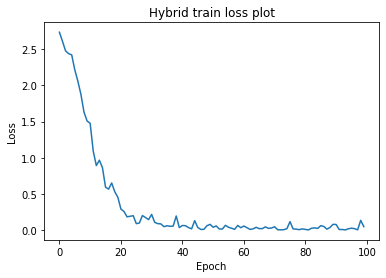

In [ ]:
show_plot(current_loss_his,'Hybrid train loss plot','Epoch','Loss')

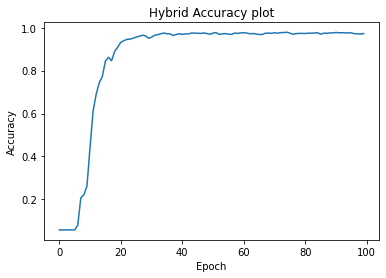

In [ ]:
show_plot(current_Acc_his,'Hybrid Accuracy plot','Epoch','Accuracy')

## 4 模型测试

In [ ]:
net.eval()   # 将模型设置为验证模式
# 测试最好的模型的结果
count = 0
# 模型测试
for inputs, _ in test_loader:
    inputs = inputs.to(device)
    outputs = net(inputs)
    outputs = np.argmax(outputs.detach().cpu().numpy(), axis=1)
    if count == 0:
        y_pred_test =  outputs
        count = 1
    else:
        y_pred_test = np.concatenate( (y_pred_test, outputs) )

# 生成分类报告
classification = classification_report(ytest, y_pred_test, digits=4)
print(classification)

              precision    recall  f1-score   support

         0.0     1.0000    0.8537    0.9211        41
         1.0     0.9919    0.9525    0.9718      1285
         2.0     0.9750    0.9920    0.9834       747
         3.0     0.9476    0.9343    0.9409       213
         4.0     0.9817    0.9862    0.9839       435
         5.0     0.9801    0.9726    0.9763       657
         6.0     0.9600    0.9600    0.9600        25
         7.0     0.9795    1.0000    0.9896       430
         8.0     0.8571    0.6667    0.7500        18
         9.0     0.9709    0.9931    0.9819       875
        10.0     0.9716    0.9891    0.9803      2210
        11.0     0.9920    0.9288    0.9594       534
        12.0     1.0000    0.9946    0.9973       185
        13.0     0.9913    0.9974    0.9943      1139
        14.0     0.9829    0.9942    0.9885       347
        15.0     0.8602    0.9524    0.9040        84

    accuracy                         0.9788      9225
   macro avg     0.9651   

In [ ]:
classification.find('weighted avg')

1028

In [ ]:
classification[classification.find('weighted avg')+17:classification.find('weighted avg')+23]

'0.9217'

In [ ]:
type(classification)

str

## 5 添加BN

In [ ]:
class_num = 16

class HybridSN_BN(nn.Module):  
  def __init__(self, in_channels=1, out_channels=class_num):
    super(HybridSN_BN, self).__init__()
    self.conv3d_features = nn.Sequential(
        nn.Conv3d(in_channels,out_channels=8,kernel_size=(7,3,3)),
        nn.BatchNorm3d(8),
        nn.ReLU(),
        nn.Conv3d(in_channels=8,out_channels=16,kernel_size=(5,3,3)),
        nn.BatchNorm3d(16),
        nn.ReLU(),
        nn.Conv3d(in_channels=16,out_channels=32,kernel_size=(3,3,3)),
        nn.BatchNorm3d(32),
        nn.ReLU()
    )

    self.conv2d_features = nn.Sequential(
        nn.Conv2d(in_channels=32 * 18, out_channels=64, kernel_size=(3,3)),
        nn.BatchNorm2d(64),
        nn.ReLU()
    )

    self.classifier = nn.Sequential(
        nn.Linear(64 * 17 * 17, 256),
        nn.ReLU(),
        nn.Dropout(p=0.4),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Dropout(p=0.4),
        nn.Linear(128, 16)
    )
 
  def forward(self, x):
    x = self.conv3d_features(x)
    x = x.view(x.size()[0],x.size()[1]*x.size()[2],x.size()[3],x.size()[4])
    x = self.conv2d_features(x)
    x = x.view(x.size()[0],-1)
    x = self.classifier(x)
    return x

In [ ]:
# 随机输入，测试网络结构是否通
x = torch.randn(4, 1, 30, 25, 25)
net_bn = HybridSN_BN()
y = net_bn(x)
print(y.shape)

torch.Size([4, 16])


In [ ]:
# 使用GPU训练，可以在菜单 "代码执行工具" -> "更改运行时类型" 里进行设置
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 网络放到GPU上
net_bn = HybridSN_BN().to(device)
# 训练
net_bn,net_bn_current_loss_his,net_bn_current_Acc_his = train(net_bn)


[Epoch: 1]   [loss avg: 21.4433]   [current loss: 2.1303]  [current acc: 0.3339]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Epoch: 2]   [loss avg: 17.8773]   [current loss: 1.4849]  [current acc: 0.4129]
[Epoch: 3]   [loss avg: 15.3112]   [current loss: 1.1899]  [current acc: 0.5230]
[Epoch: 4]   [loss avg: 13.3365]   [current loss: 0.9701]  [current acc: 0.6484]
[Epoch: 5]   [loss avg: 11.8137]   [current loss: 0.6020]  [current acc: 0.8549]
[Epoch: 6]   [loss avg: 10.4606]   [current loss: 0.5055]  [current acc: 0.8928]
[Epoch: 7]   [loss avg: 9.3524]   [current loss: 0.3659]  [current acc: 0.9058]
[Epoch: 8]   [loss avg: 8.4483]   [current loss: 0.2106]  [current acc: 0.9447]
[Epoch: 9]   [loss avg: 7.6865]   [current loss: 0.2823]  [current acc: 0.9545]
[Epoch: 10]   [loss avg: 7.0392]   [current loss: 0.1205]  [current acc: 0.9706]
[Epoch: 11]   [loss avg: 6.5182]   [current loss: 0.0947]  [current acc: 0.9620]
[Epoch: 12]   [loss avg: 6.0511]   [current loss: 0.0936]  [current acc: 0.9761]
[Epoch: 13]   [loss avg: 5.6462]   [current loss: 0.1242]  [current acc: 0.9704]
[Epoch: 14]   [loss avg: 5.2935

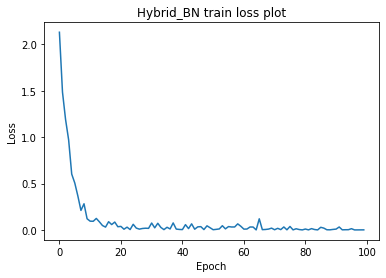

In [ ]:
show_plot(net_bn_current_loss_his,'Hybrid_BN train loss plot','Epoch','Loss')

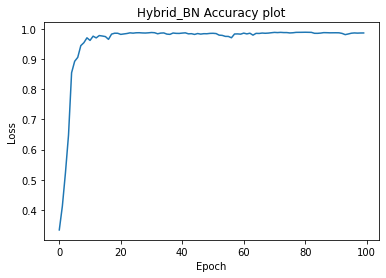

In [ ]:
show_plot(net_bn_current_Acc_his,'Hybrid_BN Accuracy plot','Epoch','Loss')

In [ ]:
net_bn.eval()   # 将模型设置为验证模式
# 最佳模型测试结果
count = 0
# 模型测试
for inputs, _ in test_loader:
    inputs = inputs.to(device)
    outputs = net_bn(inputs)
    outputs = np.argmax(outputs.detach().cpu().numpy(), axis=1)
    if count == 0:
        y_pred_test =  outputs
        count = 1
    else:
        y_pred_test = np.concatenate( (y_pred_test, outputs) )

# 生成分类报告
classification = classification_report(ytest, y_pred_test, digits=4)
print(classification)

              precision    recall  f1-score   support

         0.0     1.0000    1.0000    1.0000        41
         1.0     0.9951    0.9556    0.9750      1285
         2.0     1.0000    0.9946    0.9973       747
         3.0     1.0000    1.0000    1.0000       213
         4.0     0.9931    0.9908    0.9919       435
         5.0     0.9910    1.0000    0.9955       657
         6.0     1.0000    1.0000    1.0000        25
         7.0     1.0000    1.0000    1.0000       430
         8.0     0.7826    1.0000    0.8780        18
         9.0     0.9865    0.9989    0.9926       875
        10.0     0.9730    0.9937    0.9832      2210
        11.0     0.9906    0.9869    0.9887       534
        12.0     1.0000    0.9838    0.9918       185
        13.0     1.0000    0.9939    0.9969      1139
        14.0     0.9971    0.9971    0.9971       347
        15.0     0.9518    0.9405    0.9461        84

    accuracy                         0.9888      9225
   macro avg     0.9788   

## 6 添加注意力机制

In [ ]:
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc1   = nn.Conv2d(in_planes, in_planes // 16, 1, bias=False)
        self.relu1 = nn.ReLU()
        self.fc2   = nn.Conv2d(in_planes // 16, in_planes, 1, bias=False)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        #print(avg_out.size())
        max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        return self.sigmoid(out)

In [ ]:
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()

        assert kernel_size in (3, 7), 'kernel size must be 3 or 7'
        padding = 3 if kernel_size == 7 else 1

        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)


In [ ]:
class_num = 16

class HybridSN_Attention(nn.Module):  
  def __init__(self, in_channels=1, out_channels=class_num):
    super(HybridSN_Attention, self).__init__()
    self.conv3d_features = nn.Sequential(
        nn.Conv3d(in_channels,out_channels=8,kernel_size=(7,3,3)),
        nn.ReLU(),
        nn.Conv3d(in_channels=8,out_channels=16,kernel_size=(5,3,3)),
        nn.ReLU(),
        nn.Conv3d(in_channels=16,out_channels=32,kernel_size=(3,3,3)),
        nn.ReLU()
    )

    self.ca = ChannelAttention(32 * 18)
    self.sa = SpatialAttention()

    self.conv2d_features = nn.Sequential(
        nn.Conv2d(in_channels=32 * 18, out_channels=64, kernel_size=(3,3)),
        nn.ReLU()
    )


    self.classifier = nn.Sequential(
        nn.Linear(64 * 17 * 17, 256),
        nn.ReLU(),
        nn.Dropout(p=0.4),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Dropout(p=0.4),
        nn.Linear(128, 16)
    )
 
  def forward(self, x):
    x = self.conv3d_features(x)
    x = x.view(x.size()[0],x.size()[1]*x.size()[2],x.size()[3],x.size()[4])

    x = self.ca(x) * x
    x = self.sa(x) * x

    x = self.conv2d_features(x)
    x = x.view(x.size()[0],-1)
    x = self.classifier(x)
    return x

In [ ]:
#随机输入，测试网络结构是否通
x = torch.randn(1, 1, 30, 25, 25)
net_attention = HybridSN_Attention()
y = net_attention(x)
print(y.shape)

torch.Size([1, 16])


In [ ]:

# 使用GPU训练，可以在菜单 "代码执行工具" -> "更改运行时类型" 里进行设置
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 网络放到GPU上
net_attention = HybridSN_Attention().to(device)
# 训练
net_attention,net_attention_current_loss_his,net_attention_current_Acc_his = train(net_attention)



[Epoch: 1]   [loss avg: 20.7003]   [current loss: 2.5078]  [current acc: 0.0574]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Epoch: 2]   [loss avg: 20.0907]   [current loss: 2.4204]  [current acc: 0.0574]
[Epoch: 3]   [loss avg: 19.6543]   [current loss: 2.3522]  [current acc: 0.0574]
[Epoch: 4]   [loss avg: 19.2176]   [current loss: 2.0047]  [current acc: 0.0574]
[Epoch: 5]   [loss avg: 18.7697]   [current loss: 2.1302]  [current acc: 0.0574]
[Epoch: 6]   [loss avg: 18.3845]   [current loss: 2.1718]  [current acc: 0.0574]
[Epoch: 7]   [loss avg: 17.9622]   [current loss: 1.8143]  [current acc: 0.1397]
[Epoch: 8]   [loss avg: 17.4237]   [current loss: 1.6888]  [current acc: 0.4112]
[Epoch: 9]   [loss avg: 16.7945]   [current loss: 1.2119]  [current acc: 0.5495]
[Epoch: 10]   [loss avg: 16.1538]   [current loss: 1.2513]  [current acc: 0.6468]
[Epoch: 11]   [loss avg: 15.4811]   [current loss: 1.0278]  [current acc: 0.7402]
[Epoch: 12]   [loss avg: 14.8138]   [current loss: 1.1311]  [current acc: 0.7650]
[Epoch: 13]   [loss avg: 14.1304]   [current loss: 0.7788]  [current acc: 0.8165]
[Epoch: 14]   [loss avg:

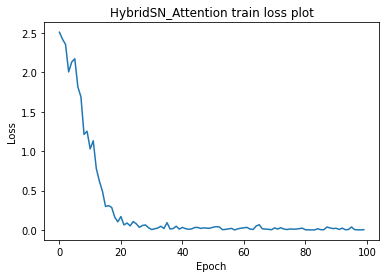

In [ ]:
show_plot(net_attention_current_loss_his,'HybridSN_Attention train loss plot','Epoch','Loss')

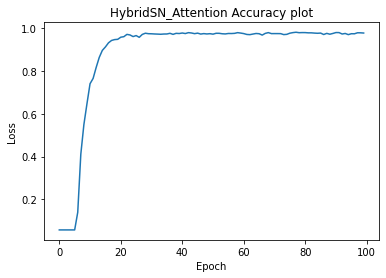

In [ ]:
show_plot(net_attention_current_Acc_his,'HybridSN_Attention Accuracy plot','Epoch','Loss')

In [ ]:
net_attention.eval()
# 最佳模型测试结果
count = 0
# 模型测试
for inputs, _ in test_loader:
    inputs = inputs.to(device)
    outputs = net_attention(inputs)
    outputs = np.argmax(outputs.detach().cpu().numpy(), axis=1)
    if count == 0:
        y_pred_test =  outputs
        count = 1
    else:
        y_pred_test = np.concatenate( (y_pred_test, outputs) )

# 生成分类报告
classification = classification_report(ytest, y_pred_test, digits=4)
print(classification)

              precision    recall  f1-score   support

         0.0     0.8667    0.9512    0.9070        41
         1.0     0.9776    0.9494    0.9633      1285
         2.0     0.9827    0.9906    0.9867       747
         3.0     0.9953    1.0000    0.9977       213
         4.0     0.9953    0.9839    0.9896       435
         5.0     0.9909    0.9970    0.9939       657
         6.0     1.0000    1.0000    1.0000        25
         7.0     1.0000    0.9837    0.9918       430
         8.0     1.0000    0.9444    0.9714        18
         9.0     0.9787    0.9954    0.9870       875
        10.0     0.9678    0.9923    0.9799      2210
        11.0     0.9696    0.9569    0.9632       534
        12.0     0.9888    0.9568    0.9725       185
        13.0     0.9930    0.9939    0.9934      1139
        14.0     0.9882    0.9625    0.9752       347
        15.0     0.9855    0.8095    0.8889        84

    accuracy                         0.9806      9225
   macro avg     0.9800   

## 7 BN+注意力机制

In [ ]:
class_num = 16

class HybridSN_BN_Attention(nn.Module):  
  def __init__(self, in_channels=1, out_channels=class_num):
    super(HybridSN_BN_Attention, self).__init__()
    self.conv3d_features = nn.Sequential(
        nn.Conv3d(in_channels,out_channels=8,kernel_size=(7,3,3)),
        nn.BatchNorm3d(8),
        nn.ReLU(),
        nn.Conv3d(in_channels=8,out_channels=16,kernel_size=(5,3,3)),
        nn.BatchNorm3d(16),
        nn.ReLU(),
        nn.Conv3d(in_channels=16,out_channels=32,kernel_size=(3,3,3)),
        nn.BatchNorm3d(32),
        nn.ReLU()
    )

    self.ca = ChannelAttention(32 * 18)
    self.sa = SpatialAttention()

    self.conv2d_features = nn.Sequential(
        nn.Conv2d(in_channels=32 * 18, out_channels=64, kernel_size=(3,3)),
        nn.BatchNorm2d(64),
        nn.ReLU()
    )


    self.classifier = nn.Sequential(
        nn.Linear(64 * 17 * 17, 256),
        nn.ReLU(),
        nn.Dropout(p=0.4),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Dropout(p=0.4),
        nn.Linear(128, 16)
    )
 
  def forward(self, x):
    x = self.conv3d_features(x)
    x = x.view(x.size()[0],x.size()[1]*x.size()[2],x.size()[3],x.size()[4])

    x = self.ca(x) * x
    x = self.sa(x) * x

    x = self.conv2d_features(x)
    x = x.view(x.size()[0],-1)
    x = self.classifier(x)
    return x

In [ ]:
# 随机输入，测试网络结构是否通
x = torch.randn(4, 1, 30, 25, 25)
net_bn_attention = HybridSN_BN_Attention()
y = net_bn_attention(x)
print(y.shape)

torch.Size([4, 16])


In [ ]:

# 使用GPU训练，可以在菜单 "代码执行工具" -> "更改运行时类型" 里进行设置
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 网络放到GPU上
net_bn_attention = HybridSN_BN_Attention().to(device)
# 训练

net_bn_attention,net_bn_attention_current_loss_his,net_bn_attention_current_Acc_his = train(net_bn_attention)



[Epoch: 1]   [loss avg: 21.3497]   [current loss: 2.1137]  [current acc: 0.0574]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Epoch: 2]   [loss avg: 17.5394]   [current loss: 1.4277]  [current acc: 0.0574]
[Epoch: 3]   [loss avg: 14.9844]   [current loss: 0.9536]  [current acc: 0.3976]
[Epoch: 4]   [loss avg: 12.9381]   [current loss: 0.6661]  [current acc: 0.6563]
[Epoch: 5]   [loss avg: 11.3838]   [current loss: 0.4718]  [current acc: 0.8436]
[Epoch: 6]   [loss avg: 10.1558]   [current loss: 0.3502]  [current acc: 0.8597]
[Epoch: 7]   [loss avg: 9.1436]   [current loss: 0.3139]  [current acc: 0.9234]
[Epoch: 8]   [loss avg: 8.2712]   [current loss: 0.1933]  [current acc: 0.9435]
[Epoch: 9]   [loss avg: 7.5358]   [current loss: 0.1894]  [current acc: 0.9411]
[Epoch: 10]   [loss avg: 6.9015]   [current loss: 0.0686]  [current acc: 0.9584]
[Epoch: 11]   [loss avg: 6.3736]   [current loss: 0.0816]  [current acc: 0.9665]
[Epoch: 12]   [loss avg: 5.9093]   [current loss: 0.0797]  [current acc: 0.9739]
[Epoch: 13]   [loss avg: 5.5296]   [current loss: 0.1165]  [current acc: 0.9562]
[Epoch: 14]   [loss avg: 5.1892

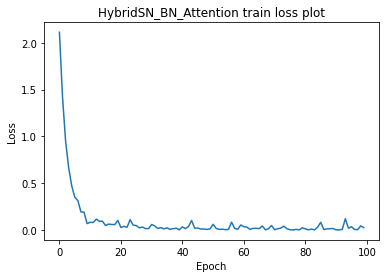

In [ ]:
show_plot(net_bn_attention_current_loss_his,'HybridSN_BN_Attention train loss plot','Epoch','Loss')

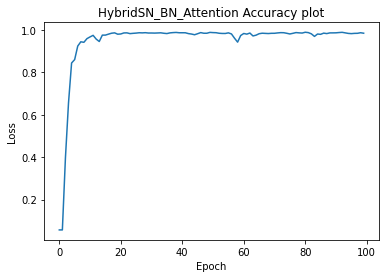

In [ ]:
show_plot(net_bn_attention_current_Acc_his,'HybridSN_BN_Attention Accuracy plot','Epoch','Loss')

In [ ]:
net_bn_attention.eval()
# 最佳模型测试结果
count = 0
# 模型测试
for inputs, _ in test_loader:
    inputs = inputs.to(device)
    outputs = net_bn_attention(inputs)
    outputs = np.argmax(outputs.detach().cpu().numpy(), axis=1)
    if count == 0:
        y_pred_test =  outputs
        count = 1
    else:
        y_pred_test = np.concatenate( (y_pred_test, outputs) )

# 生成分类报告
classification = classification_report(ytest, y_pred_test, digits=4)
print(classification)

              precision    recall  f1-score   support

         0.0     1.0000    0.9756    0.9877        41
         1.0     0.9952    0.9634    0.9790      1285
         2.0     0.9906    0.9906    0.9906       747
         3.0     1.0000    0.9812    0.9905       213
         4.0     0.9954    0.9885    0.9919       435
         5.0     0.9865    1.0000    0.9932       657
         6.0     1.0000    1.0000    1.0000        25
         7.0     1.0000    1.0000    1.0000       430
         8.0     1.0000    0.8333    0.9091        18
         9.0     0.9820    0.9966    0.9892       875
        10.0     0.9799    0.9932    0.9865      2210
        11.0     0.9962    0.9775    0.9868       534
        12.0     0.9787    0.9946    0.9866       185
        13.0     0.9956    0.9991    0.9974      1139
        14.0     0.9913    0.9827    0.9870       347
        15.0     0.9111    0.9762    0.9425        84

    accuracy                         0.9884      9225
   macro avg     0.9877   

## 8 所有结果比较

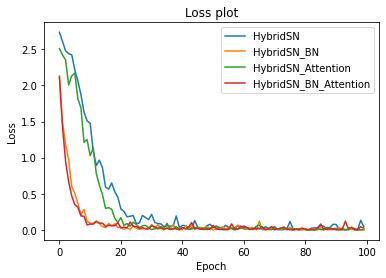

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
 
x = np.array(list(range(100)))
fig,ax = plt.subplots()
ax.plot(x,current_loss_his,label='HybridSN')
ax.plot(x,net_bn_current_loss_his,label='HybridSN_BN')
ax.plot(x,net_attention_current_loss_his,label='HybridSN_Attention')
ax.plot(x,net_bn_attention_current_loss_his,label='HybridSN_BN_Attention')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Loss plot')
ax.legend()
plt.show()


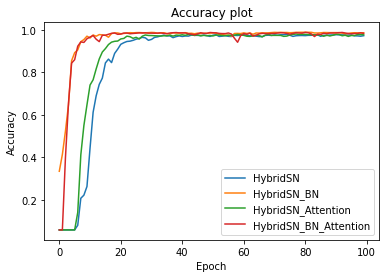

In [ ]:

x = np.array(list(range(100)))
fig,ax = plt.subplots()
ax.plot(x,current_Acc_his,label='HybridSN')
ax.plot(x,net_bn_current_Acc_his,label='HybridSN_BN')
ax.plot(x,net_attention_current_Acc_his,label='HybridSN_Attention')
ax.plot(x,net_bn_attention_current_Acc_his,label='HybridSN_BN_Attention')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy plot')
ax.legend()
plt.show()


## 9 备用函数

下面是用于计算各个类准确率，显示结果的备用函数，以供参考

In [ ]:
from operator import truediv

def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc


def reports (test_loader, y_test, name):
    count = 0
    # 模型测试
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = net(inputs)
        outputs = np.argmax(outputs.detach().cpu().numpy(), axis=1)
        if count == 0:
            y_pred =  outputs
            count = 1
        else:
            y_pred = np.concatenate( (y_pred, outputs) )

    if name == 'IP':
        target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Stone-Steel-Towers']
    elif name == 'SA':
        target_names = ['Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow','Fallow_rough_plow','Fallow_smooth',
                        'Stubble','Celery','Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green_weeds',
                        'Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk','Lettuce_romaine_7wk',
                        'Vinyard_untrained','Vinyard_vertical_trellis']
    elif name == 'PU':
        target_names = ['Asphalt','Meadows','Gravel','Trees', 'Painted metal sheets','Bare Soil','Bitumen',
                        'Self-Blocking Bricks','Shadows']
    
    classification = classification_report(y_test, y_pred, target_names=target_names)
    oa = accuracy_score(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(y_test, y_pred)
    
    return classification, confusion, oa*100, each_acc*100, aa*100, kappa*100

检测结果写在文件里：

In [ ]:
classification, confusion, oa, each_acc, aa, kappa = reports(test_loader, ytest, 'IP')
classification = str(classification)
confusion = str(confusion)
file_name = "classification_report.txt"

with open(file_name, 'w') as x_file:
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

下面代码用于显示分类结果：

In [ ]:
# load the original image
X = sio.loadmat('Indian_pines_corrected.mat')['indian_pines_corrected']
y = sio.loadmat('Indian_pines_gt.mat')['indian_pines_gt']

height = y.shape[0]
width = y.shape[1]

X = applyPCA(X, numComponents= pca_components)
X = padWithZeros(X, patch_size//2)

# 逐像素预测类别
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        if int(y[i,j]) == 0:
            continue
        else :
            image_patch = X[i:i+patch_size, j:j+patch_size, :]
            image_patch = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1)
            X_test_image = torch.FloatTensor(image_patch.transpose(0, 4, 3, 1, 2)).to(device)                                   
            prediction = net(X_test_image)
            prediction = np.argmax(prediction.detach().cpu().numpy(), axis=1)
            outputs[i][j] = prediction+1
    if i % 20 == 0:
        print('... ... row ', i, ' handling ... ...')

In [ ]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(5,5))